In [1]:
import numpy as np
import sympy as sp 
import pandas as pd
import os
from sympy import assoc_legendre
import matplotlib.pyplot as plt

In [2]:
l,m = sp.symbols('l,m',real=True)
x,y,z = sp.symbols('x,y,z',real=True,positive=True)
r,theta,phi = sp.symbols('r,theta,phi')

# function to convert spherical coords to cartesian 
def SphericalToCartesian(f):
  return f.subs([(r,sp.sqrt(x**2 + y**2 + z**2)),
                 (theta,sp.acos(z/sp.sqrt(x**2 + y**2 + z**2))),
                 (phi,sp.asin(y/sp.sqrt(x**2 + y**2)))])

In [3]:
# function to generate basis function in cartisian coords 
def basisFunction(l,m):
  l+=1
  c_plus = sp.factorial(l-1) * (-2)**(sp.Abs(m)) /sp.factorial(l + m) * sp.cos(m * phi)
  c_negt = sp.factorial(l-1) * (-2)**(sp.Abs(m)) /sp.factorial(l + sp.Abs(m)) * sp.sin(sp.Abs(m) * phi)

  s_plus  = SphericalToCartesian(c_plus* r**l * assoc_legendre(l,m,sp.cos(theta)))
  s_minus = SphericalToCartesian(c_negt* r**l * assoc_legendre(l,sp.Abs(m),sp.cos(theta)))
  
  if m >= 0:
    return [sp.expand_trig(sp.diff(s_plus, axis)).simplify() for axis in [x,y,z]]
  else:
    return [sp.expand_trig(sp.diff(s_minus, axis)).simplify().expand() for axis in [x,y,z]]

In [4]:
# get the array of basis fucntion upto order l as a function of x,y,z
def basis_upto_order(l):
  Phi= [[basisFunction(i,j)[k] for i in range(l+1) for j in range(-i-1,i+2)] for k in range(3)]
  Phi_lambda = [sp.lambdify((x,y,z),Phi[i]) for i in range(3)]
  Phi_X,Phi_Y,Phi_Z = Phi_lambda[0],Phi_lambda[1],Phi_lambda[2]
  return Phi_X,Phi_Y,Phi_Z

In [5]:
# get the all the basis function upto order 3 
Phi_X,Phi_Y,Phi_Z = basis_upto_order(3)

In [6]:
os.chdir('C:\\Users\\PPA25\\Desktop\\BV_data_Bo')

In [7]:
# load the bv data from comsol 
bv = pd.read_csv('field_at_probeloc.txt',comment='%',delim_whitespace=' ',header=None)
bv.columns = ['x','y','z','Bx','By','Bz']

In [8]:
# the best probe location for Bx,By and Bz
x_bv_idx = [11,16,17,18,19]
y_bv_idx = []
z_bv_idx = [0,1,2,3,4,5,6,7,8,9,10,12,13,14,15]

In [9]:
# get the boundary values for single axis probes 
x_bv = np.array([bv.iloc[i][['x','y','z']] for i in x_bv_idx]) # x bv loc
y_bv = np.array([bv.iloc[i][['x','y','z']] for i in y_bv_idx]) # y bv loc
z_bv = np.array([bv.iloc[i][['x','y','z']] for i in z_bv_idx]) # z bv loc

Bx_bv = np.array([bv.iloc[i]['Bx'] for i in x_bv_idx]) # Bx bv 
By_bv = np.array([bv.iloc[i]['By'] for i in y_bv_idx]) # By bv 
Bz_bv = np.array([bv.iloc[i]['Bz'] for i in z_bv_idx]) # Bz bv 

In [10]:
# find the coeffcients(G) using z BV 
A_z = np.array(list(map(Phi_Z,*z_bv.T)))
G_z = np.linalg.pinv(A_z)@Bz_bv

In [11]:
# axis scan data 
x_scan = pd.read_csv('x_axis_scan_data.txt',comment='%',delim_whitespace=' ',header=None)
x_scan.columns = ['x','y','z','Bx','By','Bz']

y_scan = pd.read_csv('y_axis_scan_data.txt',comment='%',delim_whitespace=' ',header=None)
y_scan.columns = ['x','y','z','Bx','By','Bz']

z_scan = pd.read_csv('z_axis_scan_data.txt',comment='%',delim_whitespace=' ',header=None)
z_scan.columns = ['x','y','z','Bx','By','Bz']

x_s = np.array(x_scan[['x','y','z']])
y_s = np.array(y_scan[['x','y','z']])
z_s = np.array(z_scan[['x','y','z']])

BSx_x,BSy_x,BSz_x = np.array(x_scan[['Bx','By','Bz']]).T
BSx_y,BSy_y,BSz_y = np.array(y_scan[['Bx','By','Bz']]).T
BSx_z,BSy_z,BSz_z = np.array(z_scan[['Bx','By','Bz']]).T

In [12]:
# use only z harmonic polynomials 

BPx_x = np.array(list(map(Phi_X,*x_s.T)))@G_z
BPy_x = np.array(list(map(Phi_Y,*x_s.T)))@G_z
BPz_x = np.array(list(map(Phi_Z,*x_s.T)))@G_z
BPx_y = np.array(list(map(Phi_X,*y_s.T)))@G_z
BPy_y = np.array(list(map(Phi_Y,*y_s.T)))@G_z
BPz_y = np.array(list(map(Phi_Z,*y_s.T)))@G_z
BPx_z = np.array(list(map(Phi_X,*z_s.T)))@G_z
BPy_z = np.array(list(map(Phi_Y,*z_s.T)))@G_z
BPz_z = np.array(list(map(Phi_Z,*z_s.T)))@G_z

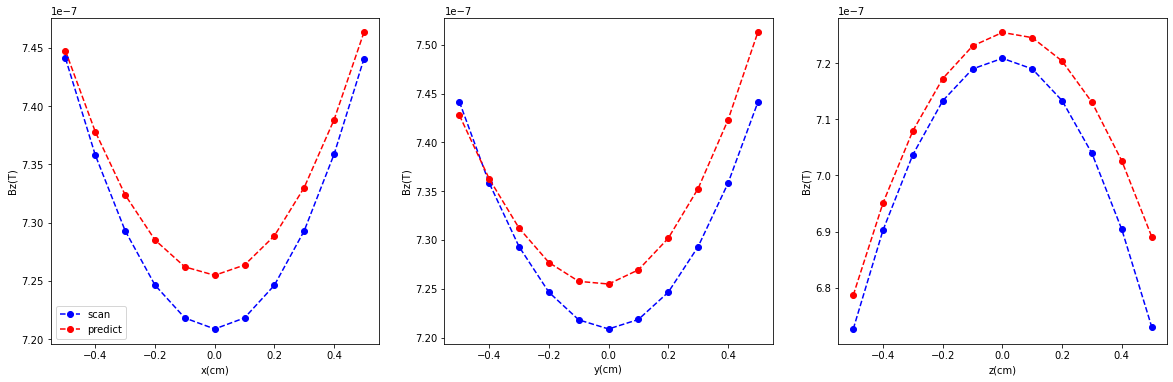

In [13]:
# plot the Bz using G_z 
fig, axes = plt.subplots( 1,3, figsize=(20,6))

#Bzx
ax = axes[0]
line1,=ax.plot(x_s[:,0],BSz_x,'bo--',label='scan')
line2,=ax.plot(x_s[:,0],BPz_x,'ro--',label='predict')
ax.set_xlabel('x(cm)')
ax.set_ylabel('Bz(T)')
ax.legend(handles=[line1, line2])

#Bzy
ax = axes[1]
ax.plot(y_s[:,1],BSz_y,'bo--')
ax.plot(y_s[:,1],BPz_y,'ro--')
ax.set_xlabel('y(cm)')
ax.set_ylabel('Bz(T)')

#Bzz
ax = axes[2]
ax.plot(z_s[:,2],BSz_z,'bo--')
ax.plot(z_s[:,2],BPz_z,'ro--')
ax.set_xlabel('z(cm)')
ax.set_ylabel('Bz(T)')

plt.savefig("field_recon_Bz.png")